In [1]:
import numpy as np
from numba import njit, prange, cuda
import pygame
import time
import matplotlib.pyplot as plt

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Global variables

In [2]:
res = 128
FHD = (1920,1080)
UHD = (3840,2160)
size = UHD

threadsperblock = (32, 32)
blockspergrid_x = int(np.ceil(size[0] / threadsperblock[0]))
blockspergrid_y = int(np.ceil(size[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

print('Threads per block',threadsperblock)
print('Blocks  per grid ',blockspergrid)

Threads per block (32, 32)
Blocks  per grid  (120, 68)


# Mandelbrot functions

$z_{n+1} = z_n^2+z_0$

In [3]:
@cuda.jit(device=True)
def iterate_mandelbrot(z,itr):
    z0 = z
    for n in range(itr):
        z = z**2 + z0
        if z.real**2 + z.imag**2 > 4:
            return n
    return -1

$z_{n+1} = z_n^2+c$

In [4]:
@cuda.jit(device=True)
def iterate_julia(z,itr,c):
    for n in range(itr):
        z = z**2 + c
        if z.real**2 + z.imag**2 > 4:
            return n
    return -1

# Coloring

In [5]:
@cuda.jit(device=True)
def color(itr):
    r,g,b = 0,0,0
    if itr == -1:
        return r,g,b
    
    n = itr % (256*6)
    if n < 256:
        r = 255
        g = n
    elif n < 512:
        r = 511 - n
        g = 255
    elif n < 768:
        g = 255
        b = n - 512
    elif n < 1024:
        g = 1023 - n
        b = 255
    elif n < 1280:
        r = n - 1024
        b = 255
    else:
        r = 255
        b = 1535 - n
    
    return r,g,b

# Interaction

In [6]:
def get_true_pos(w,h,pos):
    global size
    mouse_pos = pygame.mouse.get_pos()
    x = w * (mouse_pos[0]/size[0] - 0.5) + pos[0]
    y = h * (mouse_pos[1]/size[1] - 0.5) + pos[1]
    return np.array([x,y])

# Display

In [7]:
@cuda.jit
def draw_mandelbrot(Z,rect,w,h,pos,max_itr):
    global size
    
    i, j = cuda.grid(2)
    
    if i + rect[0] < size[0] and j + rect[1] < size[1]:
        a = ( rect[0] + i )*w / size[0] - w/2 + pos[0]
        b = ( rect[1] + j )*h / size[1] - h/2 + pos[1]
        
        itr = iterate_mandelbrot(np.clongdouble(a+b*1j),max_itr)
        r,g,b = color(itr)
        Z[i + rect[0],j + rect[1],0] = r
        Z[i + rect[0],j + rect[1],1] = g
        Z[i + rect[0],j + rect[1],2] = b

In [8]:
@cuda.jit
def draw_julia(Z,rect,w,h,pos,pos_m,max_itr):
    global size
    
    i, j = cuda.grid(2)
    
    if i + rect[0] < size[0] and j + rect[1] < size[1]:
        a = ( rect[0] + i )*w / size[0] - w/2 + pos[0]
        b = ( rect[1] + j )*h / size[1] - h/2 + pos[1]
        
        itr = iterate_julia(np.clongdouble(a+b*1j),max_itr,np.clongdouble(pos_m[0]+pos_m[1]*1j))
        r,g,b = color(itr)
        Z[i + rect[0],j + rect[1],0] = r
        Z[i + rect[0],j + rect[1],1] = g
        Z[i + rect[0],j + rect[1],2] = b

# Main code

In [9]:
def main():
    global size, res, threadsperblock, blockspergrid, gridshape
    
    pygame.init()
    screen = pygame.display.set_mode(size)
    t0 = time.time()
    
    ########## Frame rate handeling (FPS) ##########
    frame_limit   = 100
    frame_period  = 0.5
    frame_update  = 0.1
    frame_storage = round(frame_limit * frame_period)
    frame_time    = np.ones((frame_storage))
    frame_t0      = time.time()
    frame_t1      = time.time()
    frame_id      = 0
    frame_story_t = []
    frame_story_f = []
    
    ########## Variables ##########
    Z = np.empty((size[0],size[1],3),dtype=np.uint8)
    fractal = 'Mandelbrot'
    
    pos = np.array([0,0],dtype=np.longdouble)
    pos_m = pos
    pos_j = pos
    
    zoom   = -1
    zoom_m = zoom
    zoom_j = zoom
    
    w, h = 2.**zoom*size[0]/res, 2.**zoom*size[1]/res
    max_itr = 1024
    update_fractal = True
    
    ########## Program loop ##########
    running = True
    while running:
        frame_t_dif = time.time() - frame_t0
        if frame_t_dif > 1 / frame_limit:
            frame_time[frame_id] = frame_t_dif
            frame_t0 = time.time()
            frame_id = (frame_id + 1) % frame_storage
            if frame_t1 > frame_update:
                frame_t1         = time.time()
                frame_total_time = 0
                frame_current    = 0
                while frame_total_time < frame_period:
                    frame_total_time += frame_time[(frame_id - frame_current) % frame_storage]
                    frame_current    += 1
                if zoom < 0:
                    A = str(round(-zoom))
                else:
                    A = '0'
                string = fractal + ' {:3.0f} FPS, zoom: {:.1f}, iterations: {:.0f}, loc x: {:.'+A+'f}, y:{:.'+A+'f}'
                pygame.display.set_caption(string.format(frame_current / frame_total_time, zoom, max_itr, pos[0], pos[1]))
                frame_story_t.append(time.time()-t0)
                frame_story_f.append(frame_current / frame_total_time)
            
            ########## Drawing the fractal ##########  
            if update_fractal:
                w, h = 2.**zoom*size[0]/res, 2.**zoom*size[1]/res
                rect = np.array([0,0,size[0],size[1]])
                if fractal == 'Mandelbrot':
                    draw_mandelbrot[blockspergrid, threadsperblock](Z,rect,w,h,pos,max_itr)
                    pos_m  = pos
                    zoom_m = zoom
                elif fractal == 'Julia':
                    draw_julia[blockspergrid, threadsperblock](Z,rect,w,h,pos,pos_m,max_itr)
                    pos_j  = pos
                    zoom_j = zoom
                surf = pygame.surfarray.make_surface(Z)
                screen.blit(surf,(0,0))
                pygame.display.flip()
                update_fractal = False
            
            ########## Events ##########
            for event in pygame.event.get():            
                if event.type == pygame.QUIT:
                    running = False
                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_ESCAPE:
                        running = False
                    
                    # chose iterations
                    if event.key == pygame.K_KP_PLUS:
                        max_itr = np.ceil(max_itr*2)
                        update_fractal = True
                    if event.key == pygame.K_KP_MINUS:
                        max_itr = np.ceil(max_itr/2)
                        update_fractal = True
                        
                    # chose fractal to draw
                    if  event.key == pygame.K_m:
                        fractal = 'Mandelbrot'
                        pos  = pos_m
                        zoom = zoom_m
                        update_fractal = True
                    if event.key == pygame.K_j:
                        fractal = 'Julia'
                        pos  = np.array([0,0],dtype=np.longdouble)
                        zoom = -1
                        update_fractal = True
                    
                if event.type == pygame.MOUSEBUTTONDOWN:
                    # left click
                    if event.button == 1:
                        pos = get_true_pos(w,h,pos)
                        zoom -= .5
                        update_fractal = True
                    # right click
                    if event.button == 3:
                        zoom += .5
                        update_fractal = True
                    # middel click
                    if event.button == 2:
                        pos = get_true_pos(w,h,pos)  
                        update_fractal = True     
    
    ######################################## End of program ########################################
    
    pygame.quit()
    
    frame_story_t = np.array(frame_story_t)
    frame_story_f = np.array(frame_story_f)
    
    plt.figure(dpi=300,figsize=(4,2))
    plt.plot(frame_story_t-1,frame_story_f,'.',ms=1,mew=0)
    plt.xlim(xmin=0)
    plt.ylim(0,frame_story_f.max()*1.1)
    plt.xlabel('Time [s]')
    plt.ylabel('Frame rate [FPS]')
    plt.title('Performance')
    plt.show()

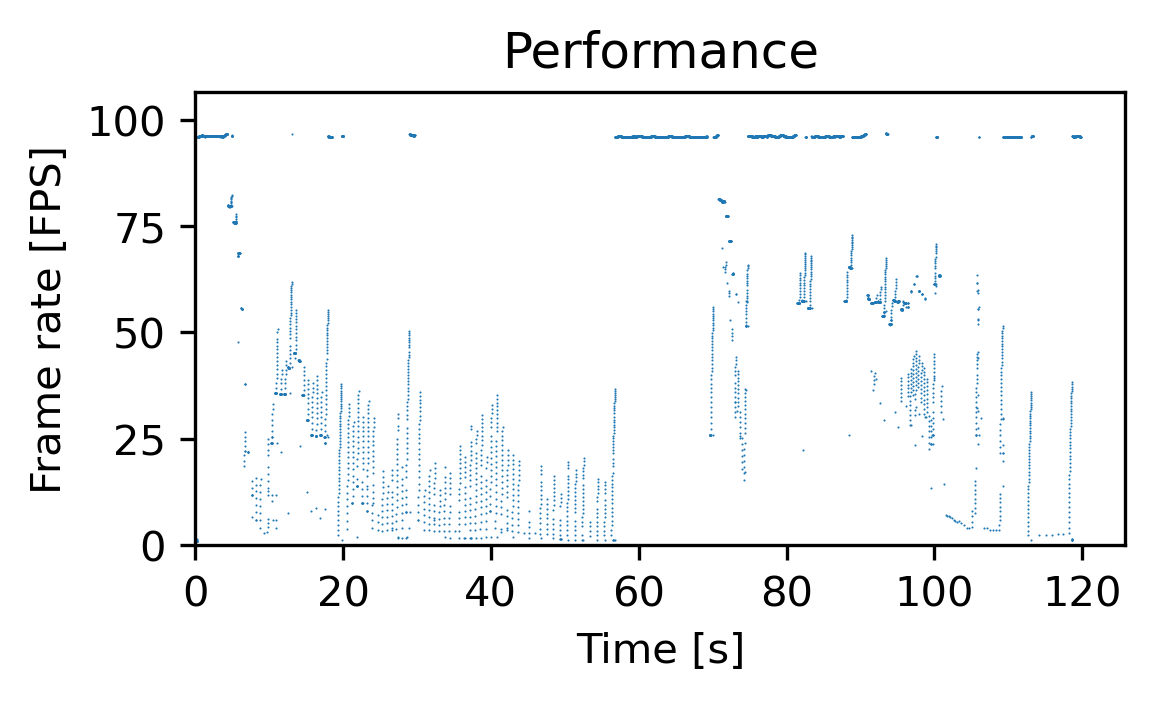

In [10]:
if __name__ == '__main__':
    main()